In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 


In [2]:
df = pd.read_csv('./location_and_label_rmNan.csv',encoding='CP949')
df

,No.,Location,ID,위험정도,일반영상,열화상영상,레이블영상,주소
0,1,wadong-dong,1,1,RGB0,THR0,LAB0,경기 파주시 와동동 1517
1,2,wadong-dong,1,1,RGB1,THR1,LAB1,경기 파주시 와동동 1517
2,3,wadong-dong,1,1,RGB2,THR2,LAB2,경기 파주시 와동동 1517
3,4,wadong-dong,1,1,RGB3,THR3,LAB3,경기 파주시 와동동 1517
4,5,wadong-dong,1,1,RGB4,THR4,LAB4,경기 파주시 와동동 1517
...,...,...,...,...,...,...,...,...
9995,9996,"seonghwa, gaesin, jungnim-dong",17,2,RGB9995,THR9995,LAB9995,충북 청주시 서원구 산남동 683
9996,9997,"seonghwa, gaesin, jungnim-dong",17,2,RGB9996,THR9996,LAB9996,충북 청주시 서원구 산남동 683
9997,9998,"seonghwa, gaesin, jungnim-dong",17,1,RGB9997,THR9997,LAB9997,충북 청주시 서원구 산남동 683
9998,9999,"seonghwa, gaesin, jungnim-dong",17,1,RGB9998,THR9998,LAB9998,충북 청주시 서원구 산남동 683


In [3]:
val = df.loc[:,["위험정도","레이블영상"]].values
danger,labPaths = val[:,0],val[:,1]
danger[:10],labPaths[:10]
dir = "targetData3"
rgbs = [os.path.join(dir,"R"+lab[3:]+'.png') for lab in labPaths]
thrs = [os.path.join(dir,"T"+lab[3:]+'.png') for lab in labPaths]
labs = [os.path.join(dir,lab+'.png') for lab in labPaths]
rgbs[:10],thrs[:10],labs[:10]


(['targetData3/R0.png',
  'targetData3/R1.png',
  'targetData3/R2.png',
  'targetData3/R3.png',
  'targetData3/R4.png',
  'targetData3/R5.png',
  'targetData3/R6.png',
  'targetData3/R7.png',
  'targetData3/R8.png',
  'targetData3/R9.png'],
 ['targetData3/T0.png',
  'targetData3/T1.png',
  'targetData3/T2.png',
  'targetData3/T3.png',
  'targetData3/T4.png',
  'targetData3/T5.png',
  'targetData3/T6.png',
  'targetData3/T7.png',
  'targetData3/T8.png',
  'targetData3/T9.png'],
 ['targetData3/LAB0.png',
  'targetData3/LAB1.png',
  'targetData3/LAB2.png',
  'targetData3/LAB3.png',
  'targetData3/LAB4.png',
  'targetData3/LAB5.png',
  'targetData3/LAB6.png',
  'targetData3/LAB7.png',
  'targetData3/LAB8.png',
  'targetData3/LAB9.png'])

In [4]:
i = 0
while i < len(rgbs):
    if not os.path.exists(rgbs[i]) or not os.path.exists(thrs[i]) or not os.path.exists(labs[i]):
        print()
        rgbs.pop(i)
        thrs.pop(i)
        labs.pop(i)
        danger = np.delete(danger,[i])
    i+=1

In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from PIL import Image
import cv2 

imgtrans = transforms.Compose([
    transforms.Resize(size=(128,256)),
    transforms.ToTensor()
])

class CompleteRgbThrDataset(torch.utils.data.Dataset):
    def __init__(self,rgbList,thrList,labList,label,imgtrans = imgtrans):
        self.rgbList = rgbList
        self.thrList = thrList
        self.labList = labList
        self.imgtrans = imgtrans
        self.label = label 
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        rgb = Image.open(self.rgbList[idx]).convert('RGB')
        thr = Image.open(self.thrList[idx]).convert('RGB')
        # lab = Image.fromarray((np.array(Image.open(self.labList[idx]).convert('L'))>=127.0).astype(np.uint8)*255)
        lab = Image.open(self.labList[idx]).convert('L')
        label = torch.LongTensor([self.label[idx]])
        if self.imgtrans:
            rgb = self.imgtrans(rgb)
            thr = self.imgtrans(thr)
            lab = self.imgtrans(lab)
        lab = (lab>=0.5).type(torch.float32)
        
        return rgb,thr,lab,label 



In [8]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
import math



class Swish(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


class ConvBNReLU(nn.Sequential):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        padding = self._get_padding(kernel_size, stride)
        super(ConvBNReLU, self).__init__(
            nn.ZeroPad2d(padding),
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding=0, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            Swish(),
        )

    def _get_padding(self, kernel_size, stride):
        p = max(kernel_size - stride, 0)
        return [p // 2, p - p // 2, p // 2, p - p // 2]

class SqueezeExcitation(nn.Module):

    def __init__(self, in_planes, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_planes, reduced_dim, 1),
            Swish(),
            nn.Conv2d(reduced_dim, in_planes, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class MBConvBlock(nn.Module):

    def __init__(self,
                 in_planes,
                 out_planes,
                 expand_ratio,
                 kernel_size,
                 stride,
                 reduction_ratio=4,
                 drop_connect_rate=0.2):
        super(MBConvBlock, self).__init__()
        self.drop_connect_rate = drop_connect_rate
        self.use_residual = in_planes == out_planes and stride == 1
        assert stride in [1, 2]
        assert kernel_size in [3, 5]

        hidden_dim = in_planes * expand_ratio
        reduced_dim = max(1, int(in_planes / reduction_ratio))

        layers = []
        # pw
        if in_planes != hidden_dim:
            layers += [ConvBNReLU(in_planes, hidden_dim, 1)]

        layers += [
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, kernel_size, stride=stride, groups=hidden_dim),
            # se
            SqueezeExcitation(hidden_dim, reduced_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, out_planes, 1, bias=False),
            nn.BatchNorm2d(out_planes),
        ]

        self.conv = nn.Sequential(*layers)

    def _drop_connect(self, x):
        if not self.training:
            return x
        keep_prob = 1.0 - self.drop_connect_rate
        batch_size = x.size(0)
        random_tensor = keep_prob
        random_tensor += torch.rand(batch_size, 1, 1, 1, device=x.device)
        binary_tensor = random_tensor.floor()
        return x.div(keep_prob) * binary_tensor

    def forward(self, x):
        if self.use_residual:
            return x + self._drop_connect(self.conv(x))
        else:
            return self.conv(x)
        


class ResConvBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.layer = torch.nn.Sequential(*[
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=(3,3),stride=1,padding=1
                                 ),
            torch.nn.BatchNorm2d(out_channels),
            Swish(),
            torch.nn.Conv2d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=(3,3),stride=1,padding=1
                                 ),
            torch.nn.BatchNorm2d(out_channels),
            Swish(),
        ])
        self.shortcut = torch.nn.Sequential(*[
            torch.nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=(1,1),stride=1),
            torch.nn.BatchNorm2d(out_channels)
        ])
    def forward(self,x):
        shortcut = self.shortcut(x)
        x = self.layer(x)
        return x + shortcut

    
class FusionBlock(torch.nn.Module):
    def __init__(self,channel,height,width):
        super(FusionBlock, self).__init__()
        self.weightT = torch.nn.Parameter(torch.rand(size=(channel,height,width),requires_grad = True))
        self.weightR = torch.nn.Parameter(torch.rand(size=(channel,height,width),requires_grad = True))
        
    def forward(self,thr,rgb):
        thrAlpha = torch.sigmoid(self.weightT)
        thrBeta = 1-thrAlpha
        
        rgbAlpha = torch.sigmoid(self.weightR)
        rgbBeta = 1-rgbAlpha
        
        thr_ = thrAlpha*thr + thrBeta*rgb
        rgb_ = rgbAlpha*rgb + rgbBeta*thr
        
        return thr_,rgb_

class MBConvIntertwinedUNet(torch.nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.n_features = [64,256,256,256,256]
        self.downsample = torch.nn.MaxPool2d(2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        

        self.rgbStem = MBConvBlock(in_planes=3,out_planes=self.n_features[0], expand_ratio=1,kernel_size=3,stride=1)
        self.thrStem = MBConvBlock(in_planes=3,out_planes=self.n_features[0], expand_ratio=1,kernel_size=3,stride=1)
        

        self.rgbLayer1 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[0],out_planes=self.n_features[1], expand_ratio=6,kernel_size=3,stride=1),
            MBConvBlock(in_planes=self.n_features[1],out_planes=self.n_features[1], expand_ratio=6,kernel_size=3,stride=1),
            ])
        
        self.thrLayer1 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[0],out_planes=self.n_features[1], expand_ratio=6,kernel_size=3,stride=1),
            MBConvBlock(in_planes=self.n_features[1],out_planes=self.n_features[1], expand_ratio=6,kernel_size=3,stride=1),
            ])

        self.rgbLayer2 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[1],out_planes=self.n_features[2], expand_ratio=6,kernel_size=3,stride=1),
            MBConvBlock(in_planes=self.n_features[2],out_planes=self.n_features[2], expand_ratio=6,kernel_size=3,stride=1),
            ])
        self.thrLayer2 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[1],out_planes=self.n_features[2], expand_ratio=6,kernel_size=3,stride=1),
            MBConvBlock(in_planes=self.n_features[2],out_planes=self.n_features[2], expand_ratio=6,kernel_size=3,stride=1),
            ])

        self.rgbLayer3 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[2],out_planes=self.n_features[3], expand_ratio=6,kernel_size=5,stride=1),
            MBConvBlock(in_planes=self.n_features[3],out_planes=self.n_features[3], expand_ratio=6,kernel_size=5,stride=1),
            ])
        self.thrLayer3 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[2],out_planes=self.n_features[3], expand_ratio=6,kernel_size=5,stride=1),
            MBConvBlock(in_planes=self.n_features[3],out_planes=self.n_features[3], expand_ratio=6,kernel_size=5,stride=1),
            ])
        
        self.rgbLayer4 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[3],out_planes=self.n_features[4], expand_ratio=6,kernel_size=5,stride=1),
            MBConvBlock(in_planes=self.n_features[4],out_planes=self.n_features[4], expand_ratio=6,kernel_size=5,stride=1),
            ])
        self.thrLayer4 = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[3],out_planes=self.n_features[4], expand_ratio=6,kernel_size=5,stride=1),
            MBConvBlock(in_planes=self.n_features[4],out_planes=self.n_features[4], expand_ratio=6,kernel_size=5,stride=1),
            ])

        self.bridge = torch.nn.Sequential(*[
            MBConvBlock(in_planes=self.n_features[4]*2,out_planes=self.n_features[4], expand_ratio=6,kernel_size=5,stride=1)

            ])
        
#         self.fuse1 = FusionBlock(channel=self.n_features[0],height=128//2,width=256//2)
#         self.fuse2 = FusionBlock(channel=self.n_features[1],height=128//4,width=256//4)
#         self.fuse3 = FusionBlock(channel=self.n_features[2],height=128//8,width=256//8)
#         self.fuse4 = FusionBlock(channel=self.n_features[3],height=128//16,width=256//16)
        
        
        self.dLayer4 = ResConvBlock(self.n_features[4]+self.n_features[3]*2,self.n_features[3])
        self.dLayer3 = ResConvBlock(self.n_features[3]+self.n_features[2]*2,self.n_features[2])
        self.dLayer2 = ResConvBlock(self.n_features[2]+self.n_features[1]*2,self.n_features[1])
        self.dLayer1 = ResConvBlock(self.n_features[1]+self.n_features[0]*2,self.n_features[0])
        
        self.out = torch.nn.Conv2d(self.n_features[0],n_class,1)
        
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                fan_out = m.weight.size(0)
                init_range = 1.0 / math.sqrt(fan_out)
                nn.init.uniform_(m.weight, -init_range, init_range)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, rgb, thr):
        thrStem = self.thrStem(thr)
        rgbStem = self.rgbStem(rgb)  # 256 
        
        
        thr = self.downsample(thrStem)
        rgb = self.downsample(rgbStem) # 128
#         thr,rgb = self.fuse1(thr,rgb)
        
        thrLayer1 = self.thrLayer1(thr)
        rgbLayer1 = self.rgbLayer1(rgb)
        
        
        thr = self.downsample(thrLayer1)
        rgb = self.downsample(rgbLayer1) # 64 
#         thr,rgb = self.fuse2(thr,rgb)
        
        thrLayer2 = self.thrLayer2(thr)
        rgbLayer2 = self.rgbLayer2(rgb)
        
        
        thr = self.downsample(thrLayer2)
        rgb = self.downsample(rgbLayer2) # 32 
#         thr,rgb = self.fuse3(thr,rgb)
        
        thrLayer3 = self.thrLayer3(thr)
        rgbLayer3 = self.rgbLayer3(rgb)
        
        
        thr = self.downsample(thrLayer3)
        rgb = self.downsample(rgbLayer3) # 16
#         thr,rgb = self.fuse4(thr,rgb)
        
        thrLayer4 = self.thrLayer4(thr)
        rgbLayer4 = self.rgbLayer4(rgb)

        sumLayer4 = self.bridge(torch.cat([rgbLayer4,thrLayer4],dim=1))
        
        
        x = self.upsample(sumLayer4)
        x = torch.cat([x,rgbLayer3,thrLayer3],dim=1)
        x = self.dLayer4(x)
        
        x = self.upsample(x)
        x = torch.cat([x,rgbLayer2,thrLayer2],dim=1)
        x = self.dLayer3(x)
        
        x = self.upsample(x)
        x = torch.cat([x,rgbLayer1,thrLayer1],dim=1)
        x = self.dLayer2(x)
        
        x = self.upsample(x)
        x = torch.cat([x,rgbStem,thrStem],dim=1)
        x = self.dLayer1(x)
        
        out = self.out(x)
        
        return out
        
model = MBConvIntertwinedUNet(n_class=1)



In [13]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


state_dict = torch.load("./MBConvNetNoFuse_gamma05.pt")
model.load_state_dict(state_dict)
model.eval()

cuda:0


MBConvIntertwinedUNet(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (rgbStem): MBConvBlock(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): ZeroPad2d(padding=[1, 1, 1, 1], value=0.0)
        (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), groups=3, bias=False)
        (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Swish()
      )
      (1): SqueezeExcitation(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
          (2): Swish()
          (3): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (2): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (thrStem): MBConvBlock(
  

In [14]:
from sklearn.model_selection import train_test_split

rgbTrain,rgbTest,thrTrain,thrTest,labTrain,labTest,danTrain,danTest = train_test_split(rgbs,thrs,labs,danger,
        test_size = 0.2,random_state = 42)
rgbTrain,rgbValid,thrTrain,thrValid,labTrain,labValid,danTrain,danValid = train_test_split(rgbTrain,thrTrain,labTrain,danTrain,
        test_size = 0.2,random_state = 42)
len(rgbTrain),len(rgbValid),len(rgbTest),len(thrTrain),len(thrValid),len(thrTest),len(labTrain),len(labValid),len(labTest),len(danTrain),len(danValid),len(danTest)

trainDataset = CompleteRgbThrDataset(rgbTrain,thrTrain,labTrain,danTrain)
validDataset = CompleteRgbThrDataset(rgbValid,thrValid,labValid,danValid)
testDataset = CompleteRgbThrDataset(rgbTest,thrTest,labTest,danTest)

batch_size = 4


trainLoader = torch.utils.data.DataLoader(
trainDataset,batch_size=batch_size,shuffle=True,num_workers=8)

validLoader = torch.utils.data.DataLoader(
validDataset,batch_size=batch_size,shuffle=True,num_workers=8)

testLoader = torch.utils.data.DataLoader(
testDataset,batch_size=batch_size,shuffle=True,num_workers=8)
len(trainLoader),len(validLoader),len(testLoader)

(1600, 400, 500)

In [48]:
import copy 
import time 
image_datasets = {
    'train': trainDataset, 'val': validDataset
}

dataloaders = {
    'train': trainLoader,
    'val': validLoader
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes


from collections import defaultdict
import torch.nn.functional as F
# from loss import dice_loss


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


def calc_loss(pred, target, metrics, bce_weight=0.5):   
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    
    return loss


def print_metrics(metrics, epoch_samples, phase = 'test'):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    


def test_model(model,loader,return_prediction=False):
    model.eval()
    
    metrics = defaultdict(float)
    epoch_samples = 0
    iouMeter = AverageMeter()
    diceMeter = AverageMeter()
    predictions = [] 
    thermals = []
    rgbs = [] 
    _labels = []
    with torch.no_grad():
        for rgb,thr,labels,danger in loader:
            rgb = rgb.to(device)
            thr = thr.to(device)
            labels = labels.to(device)             

            outputs = model(rgb,thr)
            if return_prediction:
                for i in range(outputs.shape[0]):
                    prediction = torch.sigmoid(outputs[i].detach())
                    predictions.append(prediction.cpu().numpy())
                    thermals.append(thr[i].cpu().detach().numpy())
                    rgbs.append(rgb[i].cpu().detach().numpy())
                    _labels.append(labels[i].cpu().detach().numpy())

            loss = calc_loss(outputs, labels, metrics)
            epoch_samples += rgb.size(0)

            iou = iou_score(outputs,labels)
            dice = dice_coef(outputs,labels)
            iouMeter.update(iou, rgb.size(0))
            diceMeter.update(dice, rgb.size(0))

        print_metrics(metrics, epoch_samples,'test')
        print('test_model ##','iou:',iouMeter.avg,'dice:',diceMeter.avg)
        epoch_loss = metrics['loss'] / epoch_samples
    return predictions,thermals,rgbs,_labels,iouMeter.avg,diceMeter.avg

    
    
def train_model(model, optimizer, scheduler, num_epochs=25,early_stop=False):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    history = {}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        
        iouMeter = AverageMeter()
        diceMeter = AverageMeter()
        valid_iouMeter = AverageMeter()
        valid_diceMeter = AverageMeter()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for rgb,thr, labels,danger in dataloaders[phase]:
                
                rgb = rgb.to(device)
                thr = thr.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(rgb,thr)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += rgb.size(0)
                
                if phase == 'train':
                    iou = iou_score(outputs,labels)
                    dice = dice_coef(outputs,labels)
                    iouMeter.update(iou, rgb.size(0))
                    diceMeter.update(dice, rgb.size(0))
                    
                if phase == 'val':
                    iou = iou_score(outputs,labels)
                    dice = dice_coef(outputs,labels)
                    valid_iouMeter.update(iou, rgb.size(0))
                    valid_diceMeter.update(dice, rgb.size(0))

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print('train iou:',iouMeter.avg,'dice:',diceMeter.avg)
        print('valid iou:',valid_iouMeter.avg,'dice:',valid_diceMeter.avg)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    if early_stop:
        model.load_state_dict(best_model_wts)
    return model

In [49]:
model = model.to(device)
outputs,thermals,rgbs,_labels,iou,dice = test_model(model,testLoader,return_prediction=True)

test: bce: 0.487138, dice: 0.125887, loss: 0.306513
test_model ## iou: 0.8372255557685737 dice: 0.9033206690826631


In [50]:
import matplotlib.pyplot  as plt 
from PIL import Image


def showSegmentation(img):
    plt.imshow(((img > 0.5).astype(np.uint8)*255).transpose((1,2,0)))
    plt.show()

def showImage(img):
    plt.imshow(((img*255).astype(np.uint8)).transpose((1,2,0)))
    plt.show()

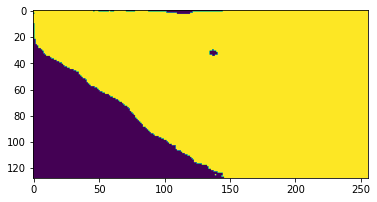

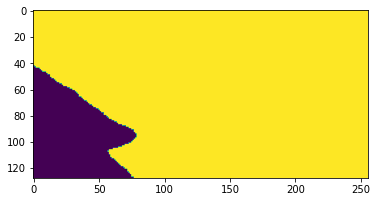

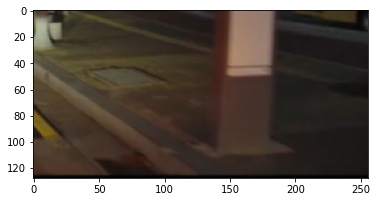

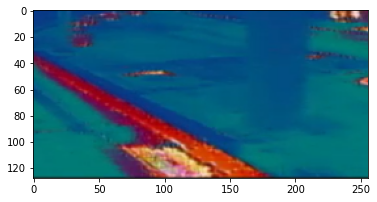

In [53]:
idx = 30

showSegmentation(outputs[idx])
showSegmentation(_labels[idx])
showImage(rgbs[idx])
showImage(thermals[idx])
